In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torchvision
from PIL import Image as im

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams["image.cmap"] = "copper"  # For immersive Mars vibe

In [4]:
x_train = pd.read_csv("./train_damaged.csv")
x_train.index = x_train.pop("Id")
x_train = x_train.to_numpy().reshape(-1, 50, 50)

y_train = pd.read_csv("./train_undamaged.csv")
y_train.index = y_train.pop("Id")
y_train = y_train.to_numpy().reshape(-1, 100, 100)

x_val = pd.read_csv("./train_damaged.csv")
x_val.index = x_val.pop("Id")
x_val = x_val.to_numpy().reshape(-1, 50, 50)

In [5]:
x_train.shape, y_train.shape, x_val.shape

((180, 50, 50), (180, 100, 100), (180, 50, 50))

In [6]:
def predict(x, batched=False):
    # Very simple prediction: Repeat every pixel once,
    # mapping a 50x50 image to 100x100
    y_pred = np.repeat(x, 2, axis=0 + batched)
    y_pred = np.repeat(y_pred, 2, axis=1 + batched)
    return y_pred

# Downsample images

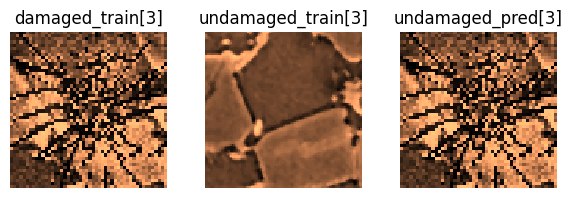

In [7]:
plt.figure(figsize=(6, 2))
i = 3

plt.subplot(131)
plt.axis("off")
plt.imshow(x_train[i], interpolation="none")
plt.title(f"damaged_train[{i}]")

plt.subplot(132)
plt.axis("off")
plt.imshow(y_train[i], interpolation="none")
plt.title(f"undamaged_train[{i}]")

plt.subplot(133)
plt.axis("off")
plt.imshow(predict(x_train[i]), interpolation="none")
plt.title(f"undamaged_pred[{i}]")

plt.tight_layout()

In [35]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.batch1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.batch2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        if in_channels != out_channels:
            self.matching_conv = nn.Conv2d(in_channels, out_channels, 1)  # 1x1 conv
        else:
            self.matching_conv = nn.Identity()

    def forward(self,x):
        residual = self.matching_conv(x)
        out = self.conv1(x)
        out = self.batch1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.batch2(out)
        out += residual
        out = self.relu2(out)
        return out

class DeConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=6, stride=2, padding=1):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.batch = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(0.25)
        self.res = ResidualBlock(in_channels+1, out_channels)

    def forward(self, x, residual):
        out = self.deconv(x)
        out = self.batch(out) # 1x24x24 residual 5x24x24
        out = torch.concatenate([residual, out], axis=1) 
        out = self.dropout(out) # 6x24x24
        out = self.res(out)
        return out

class ResUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout2d(0.25)

        self.res1 = ResidualBlock(1, 5)
        self.maxpool1 = nn.MaxPool2d(3, stride=2) # 5x24x24

        self.res3 = ResidualBlock(5, 5)

        self.deconv2 = DeConvBlock(5, 1)

        self.act = nn.Sigmoid()

    def forward(self,x):
        conv1 = self.res1(x) # 5x50x50
        pool1 = self.maxpool1(conv1) # 5x24x24
        pool1 = self.dropout(pool1) # 5x24x24

        conv3 = self.res3(pool1) # 5x24x24
       
        deconv2 = self.deconv2(conv3, conv1)
        
        output = self.act(deconv2)

        return output

    @torch.no_grad()
    def predict(self, x):
        y = self.forward(x)
        output = torch.argmax(y, dim=1)

        return output


In [9]:
def downsize(a):
    assert a.shape == (100,100)

    xaxis = np.arange(0,100,2).reshape(-1,1)
    yaxis = np.arange(0,100,2)
    return (a[xaxis,yaxis] + 
           a[xaxis+1,yaxis]+
           a[xaxis,yaxis+1]+
           a[xaxis+1,yaxis+1])/4

In [10]:
y_50_50 = []
for y in y_train:
    y_down = downsize(y)
    y_50_50.append(y_down)
    
y_train_down = np.array(y_50_50)
y_train_down.shape

(180, 50, 50)

In [11]:
class EasyNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.bn = nn.BatchNorm2d(5)
        self.conv = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3) #  in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        
        
        self.deconv = nn.ConvTranspose2d(in_channels=5, out_channels=1, kernel_size=3) # torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
        self.act = nn.Sigmoid()
        
    def forward(self,x):
        
        out = self.conv(x)
        out = self.act(out)
        out = self.bn(out)
        out = self.deconv(out)
        out = self.act(out)
        #print(out.shape)
        
        return out 
        

In [63]:
def train(model: torch.nn.Module,
          x_train: np.ndarray,
          y_train: np.ndarray,
          #f_loss: torch.nn.modules.loss,
          optimizer: torch.optim.Optimizer,
          num_epochs=20
         ):
    
    model.train()
    losses = []
    
    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        output = model.forward(x_train)

        #print(output.shape)
        #print(y_train.shape)
        loss = loss_fn(output, y_train)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        with torch.no_grad():
            losses += [loss.item()]
            if epoch % 5 == 0:
                print(f"epoch: {loss.item()}")

    return losses

In [13]:
x_train_torch = torch.tensor(x_train[:, np.newaxis, ...], dtype=torch.float32, requires_grad=True)
y_train_torch = torch.tensor(y_train_down[:, np.newaxis, ...], dtype=torch.float32, requires_grad=True)
x_train_torch.dtype, x_train_torch.shape

(torch.float32, torch.Size([180, 1, 50, 50]))

In [72]:
model = ResUNet()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_loss = train(model, x_train_torch, y_train_torch, optimizer, num_epochs=200)

epoch: 0.07613805681467056
epoch: 0.06583941727876663
epoch: 0.05844476446509361
epoch: 0.05241656303405762
epoch: 0.04808439686894417
epoch: 0.04451800510287285
epoch: 0.04046044871211052
epoch: 0.0376087985932827
epoch: 0.03472749516367912
epoch: 0.03313526511192322
epoch: 0.030633024871349335
epoch: 0.02955528348684311
epoch: 0.028157690539956093
epoch: 0.026890473440289497
epoch: 0.026164192706346512
epoch: 0.025528009980916977
epoch: 0.025038298219442368
epoch: 0.02470594272017479
epoch: 0.024511193856596947
epoch: 0.024267083033919334
epoch: 0.024196024984121323
epoch: 0.023855295032262802
epoch: 0.023716161027550697
epoch: 0.023793598636984825
epoch: 0.0237045269459486
epoch: 0.02363414689898491
epoch: 0.02351205237209797
epoch: 0.023666387423872948
epoch: 0.02345505729317665
epoch: 0.023497695103287697
epoch: 0.02334420382976532
epoch: 0.023432569578289986
epoch: 0.02342357113957405
epoch: 0.023371664807200432
epoch: 0.02338225208222866
epoch: 0.023285221308469772
epoch: 0.0232

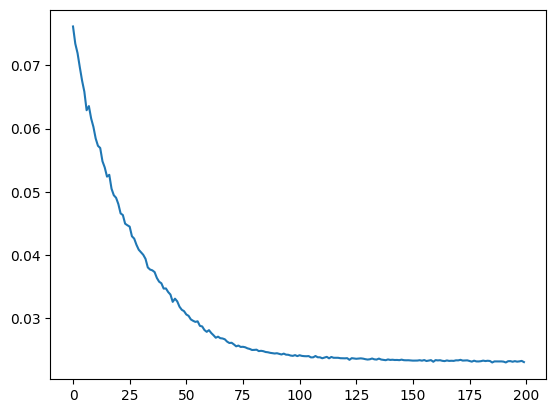

In [73]:
plt.plot(range(len(train_loss)), train_loss)

In [68]:
x_train_torch[0].shape

torch.Size([1, 50, 50])

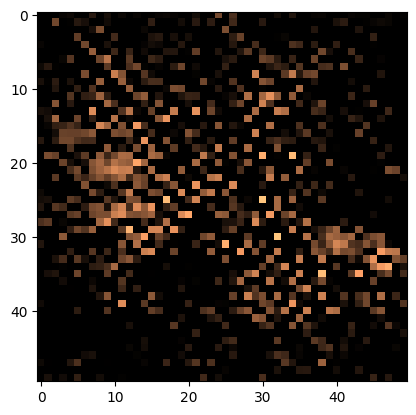

In [74]:
example = x_train_torch[0]
res = model.forward(example[np.newaxis,:])
res = torch.squeeze(res).detach().numpy()
plt.imshow(res)

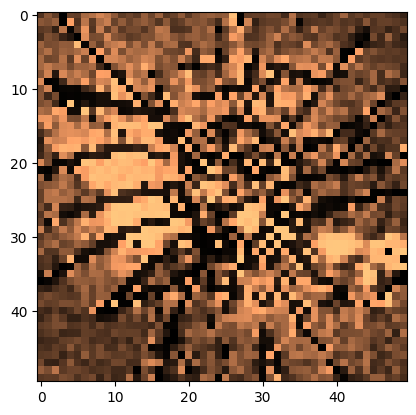

In [70]:
plt.imshow(x_train[0])

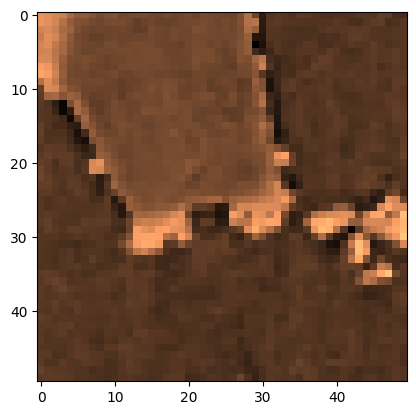

In [ ]:
plt.imshow(y_train_down[0])

In [ ]:
# Predict y_val
y_pred = predict(x_val, batched=True)

# Reshape to N x 10_000
y_pred = y_pred.reshape(y_pred.shape[0], -1)

# Create dataframe with "Id" column and save
y_df = pd.DataFrame(y_pred)
y_df.index.name = "Id"
y_df.to_csv("submission.csv")